# Unity Assignment - install probability prediction

Goal: Predict install probability for add install event given a set of features. 

## Task description

The data is a sample from our production environment. Each row refers to an impression (start of a video ad belonging to the specific campaign), and includes input features and an install label indicating whether the impression resulted in the install of the advertised game or not.

Input features and install label are provided for the training data (trainingData.csv). The test data (testData.csv) includes only the input features. Your task is to predict install probability for all the available impressions in the test data.

Return: 
1. Predicted install probability for each impression Id in the test data.
2. Source code for your solution. Feel free to select language/tools that you see appropriate.
3. A report in which you explain/justify your choices and analyze your solution.

Notice: There is no one single correct solution. You may also provide ideas how you would continue after your proposed solution.

## The data

<a id='TL;DR'></a>
<div class=" alert alert-warning">
    <b>tl;dr.</b> 

  <li>The ultimate task is to recommend ads but the problem statement is not acknowledging this. Rather than modelling $p(y|x)$, where $y$ is the install event and $x$ contains the features and the action $a=$campaignId, it would be more suitable to model $p(y|x,a)$ from the data. The conceptual difference is that $x$ is assumed to be given and we do not have any control in its creation, while, $a$ is our action. This is my main criticism to the task, as I think the prediction and recommendation should be modelled jointly (and not having a model for recommending campaigns and then using the recommendation as part of the feature space of a model for predicting installs. </li>
  <li>To create a representation for the action, we could have exploited the user interactions with the advertised ads by creating user ID vs campaign ID matrix and use a function (e.g., latent factorization) of it for action representation, but the user ID is missing from the data. </li>
  <li>User ID (history of campaigns recommended) is missing from the data but potentially important. I guess you have this as you compute features such as installCount.</li>
  <li>I have done many quick sub-optimal hacks for feature engineering. These hacks are not the best ways to handle the data. My aim was to try to not add many features for categorical data decoding at this stage, as I was more interested to just investigate a baseline solution and the feature contributions.</li>
  <li>Quick summary of engineerings: I am removing the two time features and creating a new one expressing the difference between those two in minutes (also took care of nulls and added suggestions for other ways to exploit the time features), I am removing some of the categorical features, and replacing others by values such as frequency, I am replacing the software version by the first integer in the string, I am replacing countries by a feature representing prior knowledge for per country install ratio (a bit cheating),... </li>
</div>
 

The following block loads the training data and prints some primitive statistics. 

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
tr_filename = "training_data.csv"
# load the whole training data (no need to chunk it!)
tr_data = pd.read_csv(tr_filename, sep=';')
# print basic statistics about the data
print(tr_data.info())
Y = tr_data['install']
print("Number of installs: {},".format(Y.sum()))
print("Percentage of installs: {:f},".format((Y.sum()/Y.shape[0])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206990 entries, 0 to 2206989
Data columns (total 17 columns):
id                 object
timestamp          object
campaignId         object
platform           object
softwareVersion    object
sourceGameId       int64
country            object
startCount         int64
viewCount          int64
clickCount         int64
installCount       int64
lastStart          object
startCount1d       int64
startCount7d       int64
connectionType     object
deviceType         object
install            int64
dtypes: int64(8), object(9)
memory usage: 286.2+ MB
None
Number of installs: 26497,
Percentage of installs: 0.012006,


The training data contains $n=2206990$ instances with $d=16$ features and the corresponding responses $y \in \{0,1\}$  indicates whether install was observed (install=1) or was not observed (install=0) after impression. The data set is very unbalanced as the occurrence of an install event is only $\%1.2$.

Let's print the first five rows of the dataset.

In [11]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None, 'display.width', 100):
    print(tr_data.head())

                         id                      timestamp                campaignId platform  \
0  5c36658fb58fad351175f0b6  2019-01-09T21:20:15.943+00:00  59687f0d896a6b0e5ce6ea15      ios   
1  5c38d5ab1c16172870186b5a  2019-01-11T17:43:07.609+00:00  59687f0d896a6b0e5ce6ea15      ios   
2  5c38815de8f4e50e256e4f9c  2019-01-11T11:43:25.168+00:00  59687f0d896a6b0e5ce6ea15      ios   
3  5c409ace532d5806d2c6a5e6  2019-01-17T15:10:06.420+00:00  59687f0d896a6b0e5ce6ea15      ios   
4  5c3904b92d798c41e7f3088a  2019-01-11T21:03:53.145+00:00  59687f0d896a6b0e5ce6ea15      ios   

  softwareVersion  sourceGameId country  startCount  viewCount  clickCount  installCount  \
0          11.4.1       1373094      US          25         24           0             2   
1            12.1       2739989      US          10          9           2             0   
2          12.1.2       1373094      US          27         26           0             0   
3          12.1.2       1217749      US          

Let's look at the null values in the data. 

In [12]:
## check for duplicated data rows --> no need. IDs are all unique
#print("There are {} duplicated rows ".format(tr_data.duplicated().sum()))

print("Number of nulls per feature:")
print(tr_data.isnull().sum())

print("number of installs in country nulls: {}".format(Y[tr_data['country'].isnull()].sum()))
print("number of installs in lastStart nulls: {}".format(Y[tr_data['lastStart'].isnull()].sum()))

Number of nulls per feature:
id                      0
timestamp               0
campaignId              0
platform                0
softwareVersion         0
sourceGameId            0
country               101
startCount              0
viewCount               0
clickCount              0
installCount            0
lastStart          163180
startCount1d            0
startCount7d            0
connectionType          0
deviceType              0
install                 0
dtype: int64
number of installs in country nulls: 1
number of installs in lastStart nulls: 2821


A quick way to handle the null values is to just discard the corresponding rows from the dataset. However, lastStart feature has a huge number of nulls where 2821 of those rows have install event (around 10 percent of the total rows with install event), therefore it is better to handle them in another way. We will take care of these in the next sections where we look deeper at individual features.

Let's look at the features one by one

In [13]:
for name in tr_data.columns:
    print(name)
    print(tr_data[name].describe(), "\n")

id
count                      2206990
unique                     2206990
top       5c362dd39722fe1afb4a52a0
freq                             1
Name: id, dtype: object 

timestamp
count                           2206990
unique                          2204923
top       2019-01-10T12:14:36.205+00:00
freq                                  3
Name: timestamp, dtype: object 

campaignId
count                      2206990
unique                        5704
top       5c3bfb0b36c2c6cc18710e7b
freq                         41740
Name: campaignId, dtype: object 

platform
count     2206990
unique          2
top       android
freq      1591868
Name: platform, dtype: object 

softwareVersion
count     2206990
unique        174
top         8.0.0
freq       360593
Name: softwareVersion, dtype: object 

sourceGameId
count    2.206990e+06
mean     3.085592e+06
std      1.376251e+07
min      1.105500e+04
25%      1.202538e+06
50%      1.631784e+06
75%      2.639966e+06
max      1.316274e+08
Name: sourceGa

### *id*: 
* Indicates the impression ID. 
* All ID's are unique. 
* This feature will be discarded.

In [14]:
# remove "id" column and save the data in a new variable
tr_data_m = tr_data.drop(columns="id")

### *timestamp* and *lastStart*:   
* **timestamp**: time of the event in UTC.
* **LastStart**: the time of users last start event (any campaign) (I assume in UTC).
* These are the two time features in the data. Potentially can be useful as:
* 1) their interaction might have an influence on the response variable. 
* 2) user's behavior may depend on the time of the day (e.g., people might be more likely to install an app in the evening or over the weekend than working hours(?)). To test this, we also need to convert the UTC time zone to a local time zone using data in the "country" feature and also add new features such as "weekend" to the data.  
* For now I only consider the first point due to my personal time constrains. 
* In the following code box, first I will also replace the nan values in 'lastStart' with the corresponding values in 'timestamp' and then I will define a new feature ('epoch_diff') as the difference in minutes between the 'timestamp' and 'lastStart', and drop the old features. 

In [15]:
# replace nan values in 'lastStart' with values in 'timestamp'
nan_idx = tr_data['lastStart'].isnull()
tr_data_m['lastStart'].loc[nan_idx] = tr_data_m['timestamp'][nan_idx]

# convert the string objects to datetime
tr_data_m['timestamp'] = pd.to_datetime(tr_data_m['timestamp'],infer_datetime_format=True)
tr_data_m['lastStart'] = pd.to_datetime(tr_data_m['lastStart'],infer_datetime_format=True)

# convert times to epoch in minutes
epoch_timestamp = pd.to_datetime(tr_data_m['timestamp']).astype(np.int64) // (10**9 * 60)
epoch_lastStart = pd.to_datetime(tr_data_m['lastStart']).astype(np.int64) // (10**9 * 60)

# create a new feature of difference in timestamp and lastStart in minutes
tr_data_m['epoch_diff'] = epoch_timestamp - epoch_lastStart

#print(tr_data_m['timestamp'][:10])
#print(tr_data_m['lastStart'][:10])
#print(tr_data_m['epoch_diff'][:10])

# remove "timestamp" column
tr_data_m = tr_data_m.drop(columns="timestamp")
tr_data_m = tr_data_m.drop(columns="lastStart")

C:\Users\Pedram\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### *campaignId*: 
* The id of the advertising campaign. 
* I guess this is all we have about the recommended ads. 
* There are 5704 unique campaigns.
* The dataset is biased based on this feature, as I guess the campainId is selected by an intelligent algorithm.
* The following code box looks at the distribution of campaigns over number of appearances and number of installs.

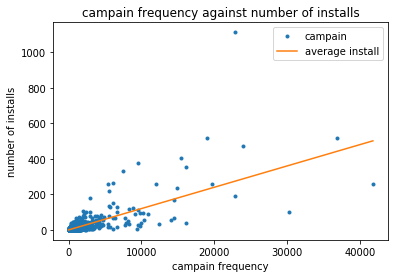

In [16]:
# compute campain frequencies
campainId_counts = tr_data_m['campaignId'].value_counts()
#find the number of installs for each campainId
install_1_frame = tr_data_m[tr_data_m['install'] == 1]
install_per_campain = np.zeros(campainId_counts.shape[0])
for i in range(campainId_counts.shape[0]):  
    install_per_campain[i] = sum(install_1_frame['campaignId'] == campainId_counts.index[i])

# plot campain frequencies against number of installs
plt.figure()
plt.plot(campainId_counts,install_per_campain,'.', label='campain')
plt.plot([0,campainId_counts[0]],[0,campainId_counts[0]*(Y.sum()/Y.shape[0])], label='average install')
plt.legend()
plt.title("campain frequency against number of installs")
plt.xlabel("campain frequency")
plt.ylabel("number of installs")

# plot install ratio for frequent campains
#install_ratio = install_per_campain/campainId_counts
#plt.figure()
#plt.plot(range(1000),100*install_ratio[:1000],'.')
#plt.title("Install ratio of popular campains (more than {} appearance)".format(campainId_counts[100]))
#plt.xlabel("frequent campains (sorted)")
#plt.ylabel("install ratio")

plt.show()

#print(campainId_counts)
#print(install_per_campain)
#print(install_ratio)

* There figure shows three things: 1) the expected correlation between number of installs and number of recommendation of the campaigns 2) huge number of campaigns have only been recommended very few times 3) A bit concerning point that there are a few extremely frequent recommended campaigns that have lower than average install ratio, while some better than average campaigns that are not recommended that frequently. This is bothersome as it may indicate a sub-optimal performance in the recommendation part.
* We need to find a good representation for campaigns (see next box)

<a id='What I would have done..'></a>
<div class=" alert alert-warning">
    <b>What I would have done...</b> 

<br />
It would be crucially important for the core recommendation task to have a feature representation for campaigns. Unfortunately, it seems that Unity does not have these information. I can think of two ways to do this: (i) try to generate features from the campaign itself (e.g., from the textual description of the campaign or the video).(ii) generate features for campaign based on the interaction data (e.g., if two users installed a couple of similar campaigns, then the information about one user can be generalized to the other one for the recommendation). It seems that approach (i) has not been successful. However, it should be possible to exploit the interaction data in (ii). For this, I would need to have a unique user ID to be able to create the sparse matrix of campaignId vs. user_id, where the elements indicate install or no-install event. I could then use matrix factorization and try to estimate this big matrix with two simpler matrix (e.g., AV), and learn these simpler (low dimensional) matrices by minimizing the reconstruction error. I would then be able to use rows of A as a feature representation for campaigns.   
</div>

* As for now, I just represent each campaign with its frequency. Please note that this is not a good (or stable) approach since as the designer of the recommender system, we are also controlling the frequency of campaign observations. Anyway, this would be hack for now (but not that optimal as we are losing a lot of information). Next code block creates this new feature.

In [17]:
# first conver the campainId_counts to a dict
campainId_dict = campainId_counts.to_dict()

campain_freq = np.zeros(tr_data_m.shape[0])
for i in range(tr_data_m.shape[0]):
    campain_freq[i] = campainId_dict[tr_data_m['campaignId'][i]]

# add the new feature to the data frame
tr_data_m.insert(1, 'campain_freq', campain_freq)

# remove 'campaignId' column
tr_data_m = tr_data_m.drop(columns="campaignId")

### *platform*: 
* User's platform (two options: android and ios)
* The following box convert this to binary feature.

In [18]:
# convert platform to binary values (1:ios, 0:android)
print(tr_data_m['platform'].value_counts())
tr_data_m['platform'] = tr_data_m['platform'] == 'ios' 
tr_data_m['platform'] = tr_data_m['platform'].astype(np.int64)

android    1591868
ios         615122
Name: platform, dtype: int64


### *softwareVersion*: 
* Software version of the device.
* There are 174 different software versions.  
* To simplify this feature, we extract the first number in the 'softwareVersion' string and consider it as the representative of the software version. The following code block builds this new feature 'softwareVersion_num' and drops 'softwareVersion' column.

In [19]:
# the following simple function finds the first number in an string
def find_first_num(input_str):
    for i, c in enumerate(input_str):
        if c.isdigit():
            start = i
            while i < len(input_str) and input_str[i].isdigit():
                i += 1
            #print('Integer %d found at position %d' % (int(input_str[start:i]), start))
            return int(input_str[start:i])
    return 0

# save the first number in the version string in an int array
soft_ver_num = np.zeros(tr_data_m.shape[0])
for i in range(tr_data_m.shape[0]):
    soft_ver_num[i] = find_first_num(tr_data_m['softwareVersion'][i])

# add the new feature to the data frame
tr_data_m.insert(1, 'softwareVersion_num', soft_ver_num)

# remove 'softwareVersion' column
tr_data_m = tr_data_m.drop(columns="softwareVersion")

# uncomment the following two lines to see how the values have changed
#print(tr_data_m['softwareVersion_num'].value_counts())
#print(tr_data['softwareVersion'].value_counts())

### *sourceGameId*: 
* The game id of the publishing game.
* Similar analysis to 'campaignId' will be applied here.

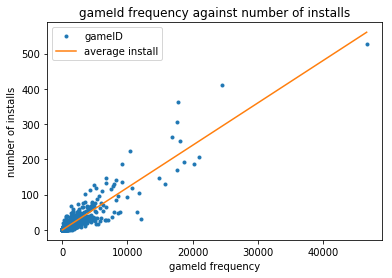

In [20]:
# compute sourceGameId frequencies
gameId_counts = tr_data_m['sourceGameId'].value_counts()
#find the number of installs for each gameId
install_1_frame = tr_data_m[tr_data_m['install'] == 1]
install_per_gameId = np.zeros(gameId_counts.shape[0])
for i in range(gameId_counts.shape[0]):  
    install_per_gameId[i] = sum(install_1_frame['sourceGameId'] == gameId_counts.index[i])

# plot gameId frequencies against number of installs
plt.figure()
plt.plot(gameId_counts,install_per_gameId,'.', label='gameID')
plt.plot([0,max(gameId_counts)],[0,max(gameId_counts)*(Y.sum()/Y.shape[0])], label='average install')
plt.legend()
plt.title("gameId frequency against number of installs")
plt.xlabel("gameId frequency")
plt.ylabel("number of installs")

plt.show()

* Clear linear correlation (probably not much information in this coding). Let's use the frequency (similar to 'campaignId') as the new feature and remove the old feature (again we are losing information but this is just a quick hack).

In [21]:
# first convert the gameId_counts to a dict
gameId_dict = gameId_counts.to_dict()

gameId_freq = np.zeros(tr_data_m.shape[0])
for i in range(tr_data_m.shape[0]):
    gameId_freq[i] = gameId_dict[tr_data_m['sourceGameId'][i]]

# add the new feature to the data frame
tr_data_m.insert(1, 'gameId_freq', gameId_freq)

# remove 'sourceGameId' column
tr_data_m = tr_data_m.drop(columns="sourceGameId")

### *country*: 
* The country of the user (total 220 countries).
* This feature can also help us to convert the time zones to local time (see explanations above).
* There are 101 nulls in this column (only one of them has install event). We drop the corresponding rows.

101
0


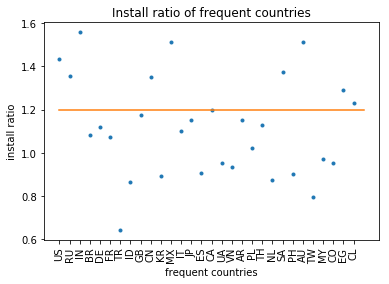

In [22]:
# drop all the nulls (they are only from from 'country' feature) the dataset.
print(tr_data_m['country'].isnull().sum())
tr_data_m.dropna(axis=0, how='any',inplace = True)
print(tr_data_m['country'].isnull().sum())
tr_data_m.reset_index(inplace=True)

# compute country frequencies
country_counts = tr_data_m['country'].value_counts()
#find the number of installs for each country
install_1_frame = tr_data_m[tr_data_m['install'] == 1]
install_per_country = np.zeros(country_counts.shape[0])
for i in range(country_counts.shape[0]):  
    install_per_country[i] = sum(install_1_frame['country'] == country_counts.index[i])

# visualize the install ratio for the most popular countries
install_per_country_ratio = install_per_country/country_counts
plt.plot(install_per_country_ratio[:30]*100,'.')
plt.plot([0,30],[100*Y.sum()/Y.shape[0],100*Y.sum()/Y.shape[0]], label='average install')
plt.xticks(rotation=90)
plt.title("Install ratio of frequent countries")
plt.xlabel("frequent countries")
plt.ylabel("install ratio")
plt.show()

#print(country_counts)
#print(install_per_country)
#print(install_per_country_ratio)    

* I will use the ratio of installs of each country as a new feature value. This to some extent justifiable as it encapsulates the prior knowledge we have about each country. At the same time it is a bit dangerous since we use the training data label information here. The following code box creates this new feature and removes the old one.

In [23]:
# first convert the install_per_country_ratio to a dict
country_dict = install_per_country_ratio.to_dict()
country_freq = np.zeros(tr_data_m.shape[0])
for i in range(tr_data_m.shape[0]):
    country_freq[i] = country_dict[tr_data_m['country'][i]]

# add the new feature to the data frame
tr_data_m.insert(1, 'country_ratio', country_freq)

# remove 'sourceGameId' column
tr_data_m = tr_data_m.drop(columns="country")

### *startCount*, *viewCount*, *clickCount*, *installCount*, *startCount1d*, and *startCount7d* : 
* **startCount**: how many times the user has ever started a campaign ever
* **viewCount**: how many times the user has ever viewed a campaign ever
* **clickCount**: how many times the user has ever clicked a campaign ever
* **installCount**: how many times the user has installed games from this network ever
* **startCount1d**: how many times user has started (any) campaigns within the last 24h
* **startCount7d**: how many times user has started (any) campaigns within the last 7 days
* These seems to be in a a good format. Let's keep them that way.


### connectionType : 
* Internet connection type (three types: wifi, cellular, none)
* The following code block creates two new features ('wifi' and 'cellular') and removes 'connectionType'.

In [24]:
print(tr_data_m['connectionType'].value_counts())

tr_data_m['wifi'] = tr_data_m['connectionType'] == 'wifi' 
tr_data_m['wifi'] = tr_data_m['wifi'].astype(np.int64)

tr_data_m['cellular'] = tr_data_m['connectionType'] == 'cellular' 
tr_data_m['cellular'] = tr_data_m['cellular'].astype(np.int64)

# remove 'connectionType' column
tr_data_m = tr_data_m.drop(columns="connectionType")

wifi        1497694
cellular     691313
none          17882
Name: connectionType, dtype: int64


###  deviceType:              
* Device model (total of 22476 models)
* Would be interesting to see if there is a different install behavior between people with more high-tech devices or people with tablets, or different brands (Iphone vs. Samsung). The following code block looks at the install ratio of most popular devices. 
* Due to my time constrains, I will remove this column for now (may get back to this later).

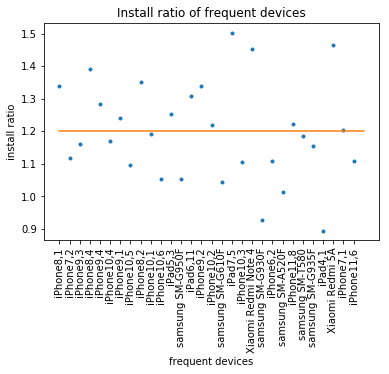

In [25]:
# compute device frequencies
device_counts = tr_data_m['deviceType'].value_counts()
#find the number of installs for each device
install_1_frame = tr_data_m[tr_data_m['install'] == 1]
install_per_device = np.zeros(device_counts.shape[0])
for i in range(device_counts.shape[0]):  
    install_per_device[i] = sum(install_1_frame['deviceType'] == device_counts.index[i])

# visualize the install ratio for the most popular device types
install_per_device_ratio = install_per_device/device_counts
plt.plot(install_per_device_ratio[:30]*100,'.')
plt.plot([0,30],[100*Y.sum()/Y.shape[0],100*Y.sum()/Y.shape[0]], label='average install')
plt.title("Install ratio of frequent devices")
plt.xticks(rotation=90)
plt.xlabel("frequent devices")
plt.ylabel("install ratio")
plt.show()

# remove 'deviceType' column for now (take care of this later)
tr_data_m = tr_data_m.drop(columns="deviceType")

Now let's look how the data looks like after the feature modifications.

In [26]:
#tr_data_m = tr_data_m.drop(columns="index")
with pd.option_context('display.max_rows', 5, 'display.max_columns', None, 'display.width', 100):
    print(tr_data_m.head())
tr_data_m

   index  country_ratio  campain_freq  gameId_freq  softwareVersion_num  platform  startCount  \
0      0       0.014333          58.0        528.0                 11.0         1          25   
1      1       0.014333          58.0        204.0                 12.0         1          10   
2      2       0.014333          58.0        528.0                 12.0         1          27   
3      3       0.014333          58.0        111.0                 12.0         1          15   
4      4       0.014333          58.0        528.0                 12.0         1          20   

   viewCount  clickCount  installCount  startCount1d  startCount7d  install  epoch_diff  wifi  \
0         24           0             2             1             8        0        1591     0   
1          9           2             0             1             4        0        2663     0   
2         26           0             0             1             2        0        2941     0   
3         14           2     

,index,country_ratio,campain_freq,gameId_freq,softwareVersion_num,platform,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,install,epoch_diff,wifi,cellular
0,0,0.014333,58.0,528.0,11.0,1,25,24,0,2,1,8,0,1591,0,1
1,1,0.014333,58.0,204.0,12.0,1,10,9,2,0,1,4,0,2663,0,1
2,2,0.014333,58.0,528.0,12.0,1,27,26,0,0,1,2,0,2941,0,1
3,3,0.014333,58.0,111.0,12.0,1,15,14,2,0,3,14,0,1152,1,0
4,4,0.014333,58.0,528.0,12.0,1,20,18,0,0,13,18,0,0,0,1
5,5,0.014333,58.0,3860.0,12.0,1,26,4,1,0,7,20,0,41,1,0
6,6,0.014333,58.0,528.0,12.0,1,38,35,0,0,9,34,0,3,1,0
7,7,0.014333,58.0,528.0,12.0,1,53,52,1,0,2,53,0,16,1,0
8,8,0.014333,58.0,5191.0,12.0,1,114,110,0,0,5,11,0,1,1,0
9,9,0.014333,58.0,5191.0,11.0,1,47,46,0,0,2,17,0,1,0,1


And finally, save the data as a csv file. I also need to save the dictionaries and other variable necessary for feature transformation (as I need to do the same on the test data).

In [27]:
# save the modified dataframe for future use
tr_data_m.to_csv(r'tr_data_m.csv', index = None)

## The Method

<a id='TL;DR'></a>
<div class=" alert alert-warning">
    <b>tl;dr.</b> 

  <li> The data is extremely unbalanced, methods with high flexibility may overfit and simpler methods will classify most points to no install class. </li>
  <li> I use under-sampling of the no install class as a quick solution to the problem. There are better (more expensive) ways to handle this but given my time this is fine. </li>
  <li> I only consider two baseline like methods in the assignment: decision tree and logistic regression. I could investigate more powerful methods but my time is limited (and I also believe that spending more time on feature engineering and extracting more features (as explained in the previous section) would probably be more fruitful.</li>
  <li> After balancing, I use 5-fold cross validation for evaluation of each method and then juts divide the training data to 2 to investigate the outputs.</li>
  <li> I use ROC and confusion matrix as the performance measure criteria</li>
  <li> Discussions about the results and modelling decisions are provided.</li>
  
</div>
 

Following code box reads the modified training data from the CSV file and remove the "index" and label ("install") columns from the data. 

In [28]:
# Load the modified training data
tr_filename = "tr_data_m.csv"
tr_data_m = pd.read_csv(tr_filename)
tr_data_m = tr_data_m.drop(columns="index")
Y = tr_data_m['install']
tr_data_m = tr_data_m.drop(columns="install")

In [29]:
# Print some basic statistics
print(tr_data_m.info())
print("number of data in class 1: {}".format(sum(Y==1)))
print("number of data in class 0: {}".format(sum(Y==0)))
tr_data_m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206889 entries, 0 to 2206888
Data columns (total 14 columns):
country_ratio          float64
campain_freq           float64
gameId_freq            float64
softwareVersion_num    float64
platform               int64
startCount             int64
viewCount              int64
clickCount             int64
installCount           int64
startCount1d           int64
startCount7d           int64
epoch_diff             int64
wifi                   int64
cellular               int64
dtypes: float64(4), int64(10)
memory usage: 235.7 MB
None
number of data in class 1: 26496
number of data in class 0: 2180393


,country_ratio,campain_freq,gameId_freq,softwareVersion_num,platform,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,epoch_diff,wifi,cellular
0,0.014333,58.0,528.0,11.0,1,25,24,0,2,1,8,1591,0,1
1,0.014333,58.0,204.0,12.0,1,10,9,2,0,1,4,2663,0,1
2,0.014333,58.0,528.0,12.0,1,27,26,0,0,1,2,2941,0,1
3,0.014333,58.0,111.0,12.0,1,15,14,2,0,3,14,1152,1,0
4,0.014333,58.0,528.0,12.0,1,20,18,0,0,13,18,0,0,1
5,0.014333,58.0,3860.0,12.0,1,26,4,1,0,7,20,41,1,0
6,0.014333,58.0,528.0,12.0,1,38,35,0,0,9,34,3,1,0
7,0.014333,58.0,528.0,12.0,1,53,52,1,0,2,53,16,1,0
8,0.014333,58.0,5191.0,12.0,1,114,110,0,0,5,11,1,1,0
9,0.014333,58.0,5191.0,11.0,1,47,46,0,0,2,17,1,0,1


###  Data standardization and balancing:              

To standardize or not to standardize? I decided to do so as the scales are quite different in different columns. However, it would make sense to also run the methods without standardization. The following code standardizes the data and saves them in data frame X. 

**Note**: The normalization should be done inside the CV folds on the training data only. However, here I do it once for both training and validation data, which is wrong but not drastically wrong given the data size that we have.

In [31]:
# the following code normalizes the data (zero mean, unit std)
from sklearn import preprocessing
# Get column names first
names = tr_data_m.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaler.fit(tr_data_m)
X = scaler.transform(tr_data_m)
X = pd.DataFrame(X, columns=names)

X

,country_ratio,campain_freq,gameId_freq,softwareVersion_num,platform,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,epoch_diff,wifi,cellular
0,0.834292,-0.601739,-0.514424,1.049261,1.608684,-0.257917,-0.151402,-0.308878,0.926130,-0.509417,-0.339733,0.024072,-1.453211,1.480647
1,0.834292,-0.601739,-0.553684,1.418532,1.608684,-0.423853,-0.341288,-0.014636,-0.369483,-0.509417,-0.455040,0.249158,-1.453211,1.480647
2,0.834292,-0.601739,-0.514424,1.418532,1.608684,-0.235792,-0.126084,-0.308878,-0.369483,-0.509417,-0.512693,0.307529,-1.453211,1.480647
3,0.834292,-0.601739,-0.564954,1.418532,1.608684,-0.368541,-0.277993,-0.014636,-0.369483,-0.333386,-0.166774,-0.068104,0.688131,-0.675380
4,0.834292,-0.601739,-0.514424,1.418532,1.608684,-0.313229,-0.227357,-0.308878,-0.369483,0.546770,-0.051468,-0.309988,-1.453211,1.480647
5,0.834292,-0.601739,-0.110671,1.418532,1.608684,-0.246854,-0.404584,-0.161757,-0.369483,0.018676,0.006185,-0.301379,0.688131,-0.675380
6,0.834292,-0.601739,-0.514424,1.418532,1.608684,-0.114105,-0.012153,-0.308878,-0.369483,0.194708,0.409757,-0.309358,0.688131,-0.675380
7,0.834292,-0.601739,-0.514424,1.418532,1.608684,0.051832,0.203051,-0.161757,-0.369483,-0.421402,0.957462,-0.306628,0.688131,-0.675380
8,0.834292,-0.601739,0.050612,1.418532,1.608684,0.726642,0.937277,-0.308878,-0.369483,-0.157355,-0.253254,-0.309778,0.688131,-0.675380
9,0.834292,-0.601739,0.050612,1.049261,1.608684,-0.014543,0.127097,-0.308878,-0.369483,-0.421402,-0.080294,-0.309778,-1.453211,1.480647


The following box performs under-sampling to take care of the unbalanceness of the data. This can be quite harmful as we are losing information by throwing the data from class 0 out. However, for now I prefer to go with this quick solution. 

* Ideally this should have been done in the cross validation loop but I will do it only once at the beginning.
* For now I am just using random undersampling. A better approach would be to cluster the data in class 0 and then use the prototypes as the representations of the class. This would be a bit expensive computationally (as k-means is expensive if there are many data), but doable (codes for this are commented bellow). See https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html for more information.

In [32]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import ClusterCentroids

# ClusterCentroids makes use of K-means to reduce the number of samples. 
#Therefore, each class will be synthesized with the centroids of the K-means method instead of the original samples
#print(sorted(Counter(Y).items()))
#cc = ClusterCentroids(random_state=0)
#X_resampled, Y_resampled = cc.fit_resample(X, Y)
#print(sorted(Counter(Y_resampled).items()))

# random undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, Y_resampled = rus.fit_resample(X, Y)
X_resampled = pd.DataFrame(X_resampled, columns=names)
print(sorted(Counter(Y_resampled).items()))

[(0, 26496), (1, 26496)]


###  Regularized logistic regression on balanced data:              
* Let's start with regularized (l2) logistic regression as a simple baseline on the balanced dataset and look at the cross validation performance.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

logreg = LogisticRegression(solver='lbfgs')

roc_auc_scores = cross_val_score(logreg, X_resampled, Y_resampled, scoring = 'roc_auc', cv=10)
print(roc_auc_scores)    

[0.61574012 0.65189213 0.60842385 0.63913734 0.66559331 0.62946899
 0.65623765 0.63272208 0.65068522 0.63493906]


It seems that the cross validation ROC scores are very close. The following plots the ROC Curve after dividing the data in two equal-size random sets.

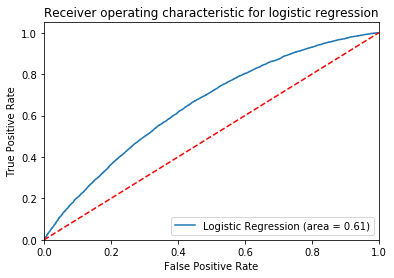

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_resampled, Y_resampled, test_size=0.5)

logreg.fit(X_train, Y_train)
y_pred_lr = logreg.predict(X_val)

logit_roc_auc = roc_auc_score(Y_val, y_pred_lr)
fpr, tpr, thresholds = roc_curve(Y_val, logreg.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The following function is used to plot the confusion matrix.

In [35]:
# This function is used to plot the confusion matrix and normalized confusion matrix
# copied from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# reference: API design for machine learning software: experiences from the scikit-learn project, Buitinck et al., 2013.
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Let's look at the confusion matrix for the validation data. 

Confusion matrix, without normalization
[[7511 5707]
 [4636 8642]]
Normalized confusion matrix
[[0.56824028 0.43175972]
 [0.34914897 0.65085103]]


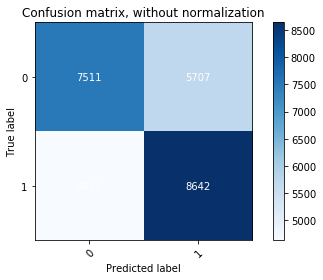

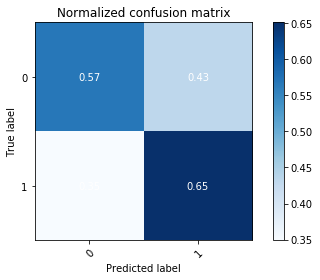

In [36]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_lr, classes=['0','1'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_lr, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Now let's train the model on all training data and look at the contribution of each coefficient.

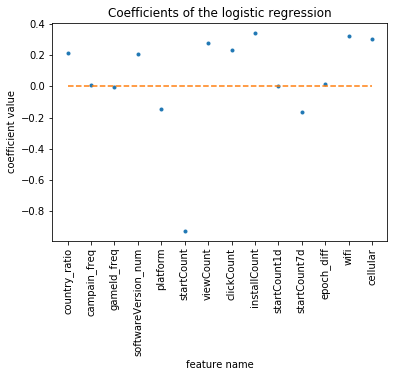

In [37]:
logreg.fit(X_resampled, Y_resampled)
# visualize the coefficients of the logistic regression
plt.plot(X_resampled.columns,logreg.coef_[0][:], '.')
plt.plot(X_resampled.columns,0 * logreg.coef_[0][:], '--')
plt.title("Coefficients of the logistic regression")
plt.xticks(rotation=90)
plt.xlabel("feature name")
plt.ylabel("coefficient value")
plt.show()

* Unsurprisingly, the coefficient corresponding to 'installCount' has the highest positive value. 
* Other contributions are also sensible, given how we simplified the features in the previous section.
* If there was time, I would go back to the previous section and try to perform a more proper representation for campainId and gameId as it seems that those two features are not contributing much. An alternative direction forward would be to use non linear methods (and feature transformations).

###  Decision tree on balanced data:     
* Let's run decision tree

[[0.56688679 0.56321948 0.57256086 0.54849972 0.56067182]
 [0.58440733 0.50287814 0.60439769 0.58816865 0.59774856]
 [0.61873054 0.52542771 0.63283385 0.61913728 0.62644164]
 [0.62973717 0.52881554 0.64350176 0.60779847 0.62751018]
 [0.63985217 0.53667493 0.6471184  0.62040823 0.63338906]
 [0.64986501 0.5396606  0.65138058 0.61163335 0.6383737 ]
 [0.63880538 0.55517586 0.63555051 0.61710964 0.64210506]
 [0.6305186  0.55379034 0.60583306 0.61924174 0.64042128]
 [0.61709551 0.53059187 0.60084038 0.6171853  0.63379657]
 [0.57369863 0.50460318 0.58591987 0.61123553 0.6222561 ]
 [0.54962503 0.48587853 0.56665342 0.59022472 0.61858852]
 [0.54309911 0.48162404 0.56448036 0.58385626 0.6127796 ]
 [0.52189963 0.47584559 0.55159006 0.57676221 0.60289103]
 [0.51959573 0.46802012 0.54415828 0.56450855 0.59104598]
 [0.50730651 0.45946149 0.54135163 0.55627392 0.58560708]
 [0.49930949 0.45384097 0.53014032 0.55018211 0.58137125]
 [0.49753766 0.45835372 0.52849699 0.543011   0.57043314]
 [0.49179719 0

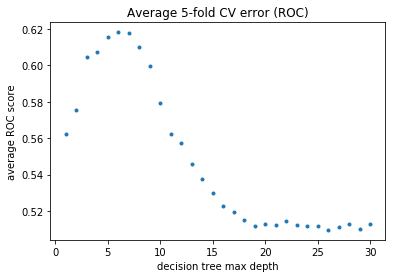

In [38]:
from sklearn.tree import DecisionTreeClassifier

max_depth = 30
# try different depths and save the CV results a
roc_scores = np.zeros([max_depth, 5]) 
for depth in range(1,max_depth+1):
    dt = DecisionTreeClassifier(max_depth=depth)
    roc_scores[depth-1,:] = cross_val_score(dt, X_resampled, Y_resampled, scoring = 'roc_auc', cv=5)

print(roc_scores)   
mean_roc = np.mean(roc_scores,1)
best_depth = np.argmax(mean_roc)+1
print("best result for depth: {}".format(best_depth))
plt.plot(range(1,len(roc_scores)+1),mean_roc,'.')
plt.title("Average 5-fold CV error (ROC)")
plt.xlabel("decision tree max depth")
plt.ylabel("average ROC score")
plt.show()   

Based on the above results, it seems that depth = 6 or 7 are reasonable choices. In the next block we use the training and validation data from the previous section to visualize the ROC curve and confusion matrix for the decision tree method.

Confusion matrix, without normalization
[[8192 5026]
 [5293 7985]]
Normalized confusion matrix
[[0.61976093 0.38023907]
 [0.39862931 0.60137069]]


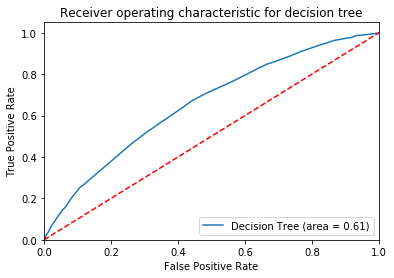

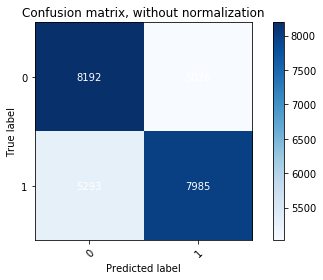

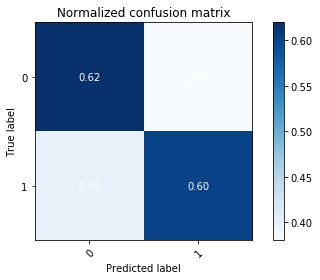

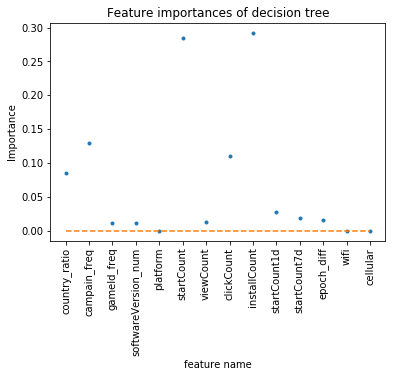

In [62]:
dt = DecisionTreeClassifier(max_depth=7)
dt.fit(X_train, Y_train)
y_pred_dt = dt.predict(X_val)

dt_roc_auc = roc_auc_score(Y_val, y_pred_dt)
fpr, tpr, thresholds = roc_curve(Y_val, dt.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for decision tree')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_dt, classes=['0','1'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_dt, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

# visualize feature importances of the model
plt.figure()
plt.plot(X_resampled.columns,dt.feature_importances_, '.')
plt.plot(X_resampled.columns,0 * dt.feature_importances_, '--')
plt.title("Feature importances of decision tree")
plt.xticks(rotation=90)
plt.xlabel("feature name")
plt.ylabel("Importance")

plt.show()

###  Random forest on balanced data:     

Here we also train a random forest. I do not have much time to fine tune the model but it seems to perform better on the validation data.

Confusion matrix, without normalization
[[8371 4847]
 [5052 8226]]
Normalized confusion matrix
[[0.63330307 0.36669693]
 [0.38047899 0.61952101]]


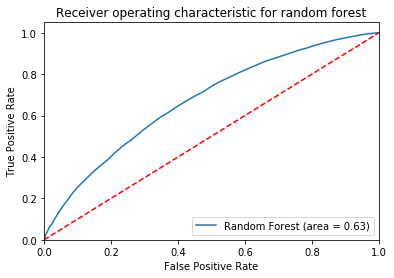

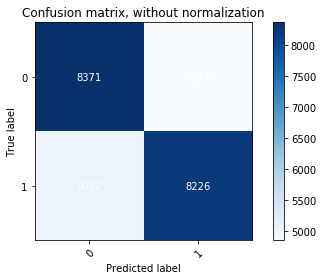

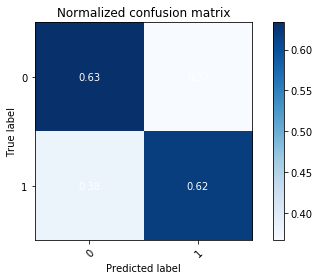

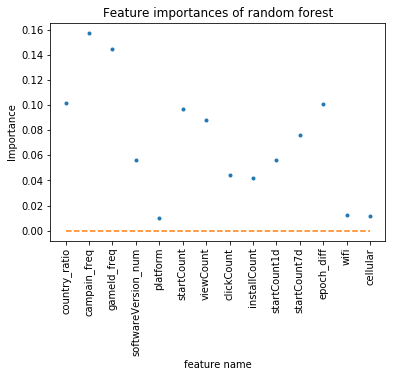

In [75]:
from sklearn.ensemble import RandomForestClassifier

#rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf = RandomForestClassifier(n_estimators=100, max_depth=100)
rf.fit(X_train, Y_train)
y_pred_rf = dt.predict(X_val)

rf_roc_auc = roc_auc_score(Y_val, y_pred_rf)
fpr, tpr, thresholds = roc_curve(Y_val, rf.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for random forest')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_rf, classes=['0','1'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_val, y_pred_rf, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

# visualize feature importances of the model
plt.figure()
plt.plot(X_resampled.columns,rf.feature_importances_, '.')
plt.plot(X_resampled.columns,0 * rf.feature_importances_, '--')
plt.title("Feature importances of random forest")
plt.xticks(rotation=90)
plt.xlabel("feature name")
plt.ylabel("Importance")

plt.show()

## Test data prediction
Given the above validation results, we will use the random forest for the test data install probability prediction. 
* Please note that we could have used more advanced methods (such as random forest or supervised deep learning methods) to learn a better feature representation and mapping for this task, However, for this assignment I am fine with the current report given my personal time.

Let's load the test data and also look at the number of nulls).

In [42]:
import csv
test_filename = "test_data.csv"
# load the whole test data (no need to chunk it!)
test_data = pd.read_csv(test_filename, sep=';',engine='python', quoting=csv.QUOTE_NONE)
# print basic statistics about the data
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740134 entries, 0 to 3740133
Data columns (total 16 columns):
id                 object
timestamp          object
campaignId         object
platform           object
softwareVersion    object
sourceGameId       int64
country            object
startCount         int64
viewCount          int64
clickCount         int64
installCount       int64
lastStart          object
startCount1d       int64
startCount7d       int64
connectionType     object
deviceType         object
dtypes: int64(7), object(9)
memory usage: 456.6+ MB
None


In [43]:
print("Number of nulls per feature:")
print(test_data.isnull().sum())
with pd.option_context('display.max_rows', 5, 'display.max_columns', None, 'display.width', 100):
    print(test_data.head())

Number of nulls per feature:
id                      0
timestamp               0
campaignId              0
platform                0
softwareVersion         0
sourceGameId            0
country               281
startCount              0
viewCount               0
clickCount              0
installCount            0
lastStart          275262
startCount1d            0
startCount7d            0
connectionType          0
deviceType              2
dtype: int64
                         id                      timestamp                campaignId platform  \
0  5c458a1e2fba59f69f8edd83  2019-01-21T09:00:14.357+00:00  58acf10efab39d013ad89c49      ios   
1  5c3af59dd750973fefae73e2  2019-01-13T08:23:57.039+00:00  58acf10efab39d013ad89c49      ios   
2  5c414bd0f8673f5fd3e5b122  2019-01-18T03:45:20.175+00:00  58acf10efab39d013ad89c49      ios   
3  5c360cb1f782910750c7376c  2019-01-09T15:01:05.852+00:00  58acf10efab39d013ad89c49      ios   
4  5c42a31dfa3f9065d6d3eba3  2019-01-19T04:10:05.419+00:0

We need to perform the same operations done on training data on the test data. However, we need to use statistics, and dictionaries that were learned from the training data. I would have ideally implemented those as functions and here would just call them again (but did not do that here). The following is the preprocessing steps:

In [44]:
# replace nan values in 'lastStart' with values in 'timestamp'
nan_idx = test_data['lastStart'].isnull()
test_data['lastStart'].loc[nan_idx] = test_data['timestamp'][nan_idx]

# convert the string objects to datetime
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'],infer_datetime_format=True)
test_data['lastStart'] = pd.to_datetime(test_data['lastStart'],infer_datetime_format=True)

# convert times to epoch in minutes
epoch_timestamp = pd.to_datetime(test_data['timestamp']).astype(np.int64) // (10**9 * 60)
epoch_lastStart = pd.to_datetime(test_data['lastStart']).astype(np.int64) // (10**9 * 60)

# create a new feature of difference in timestamp and lastStart in minutes
test_data['epoch_diff'] = epoch_timestamp - epoch_lastStart

# convert the campains to frequency, based on values learned from training data
campain_freq = np.zeros(test_data.shape[0])
for i in range(test_data.shape[0]):
    if test_data['campaignId'][i] in campainId_dict.keys():
        campain_freq[i] = campainId_dict[test_data['campaignId'][i]]
    else:
        campain_freq[i] = 1    

# add the new feature to the data frame
test_data.insert(1, 'campain_freq', campain_freq)

# convert platform to binary values (1:ios, 0:android)
test_data['platform'] = test_data['platform'] == 'ios' 
test_data['platform'] = test_data['platform'].astype(np.int64)

# save the first number in the version string in an int array
soft_ver_num = np.zeros(test_data.shape[0])
for i in range(test_data.shape[0]): 
    soft_ver_num[i] = find_first_num(test_data['softwareVersion'][i])

# add the new feature to the data frame
test_data.insert(1, 'softwareVersion_num', soft_ver_num)

# convert the gameId to frequency, based on values learned from training data
gameId_freq = np.zeros(test_data.shape[0])
for i in range(test_data.shape[0]):
    if test_data['sourceGameId'][i] in gameId_dict.keys():
        gameId_freq[i] = gameId_dict[test_data['sourceGameId'][i]]
    else:
        gameId_freq[i] = 1 
        
# add the new feature to the data frame
test_data.insert(1, 'gameId_freq', gameId_freq)

# convert the country to frequency, based on values learned from training data
country_freq = np.zeros(test_data.shape[0])
for i in range(test_data.shape[0]):
    if test_data['country'][i] in country_dict.keys():
        country_freq[i] = country_dict[test_data['country'][i]]
    else:
        country_freq[i] = 0.01 # a default number a bit smaller than the prior install probability

# add the new feature to the data frame
test_data.insert(1, 'country_ratio', country_freq)

# create connectionType features
test_data['wifi'] = test_data['connectionType'] == 'wifi' 
test_data['wifi'] = test_data['wifi'].astype(np.int64)
test_data['cellular'] = test_data['connectionType'] == 'cellular' 
test_data['cellular'] = test_data['cellular'].astype(np.int64)

C:\Users\Pedram\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Drop columns that were modified.

In [45]:
# remove "id" column
test_data = test_data.drop(columns="id")
# remove "timestamp" column
test_data = test_data.drop(columns="timestamp")
test_data = test_data.drop(columns="lastStart")
# remove 'campaignId' column
test_data = test_data.drop(columns="campaignId")
# remove 'softwareVersion' column
test_data = test_data.drop(columns="softwareVersion")
# remove 'sourceGameId' column
test_data = test_data.drop(columns="sourceGameId")
# remove 'country' column
test_data = test_data.drop(columns="country")
# remove 'connectionType' column
test_data = test_data.drop(columns="connectionType")
# remove 'deviceType' column for now (take care of this later)
test_data = test_data.drop(columns="deviceType")

Save the modified test data for later use.

In [47]:
# save the modified testdata dataframe for future use
test_data.to_csv(r'test_data_m.csv', index = None)

In [46]:
# let's look at the test data
with pd.option_context('display.max_rows', 5, 'display.max_columns', None, 'display.width', 100):
    print(test_data.head())
test_data

   country_ratio  gameId_freq  softwareVersion_num  campain_freq  platform  startCount  viewCount  \
0       0.013523        220.0                 11.0           1.0         1          32          9   
1       0.013523         65.0                  9.0           1.0         1         104         84   
2       0.013523         18.0                  8.0           1.0         1          93         81   
3       0.013523          3.0                 12.0           1.0         1          13          8   
4       0.013523        489.0                 11.0           1.0         1           4          3   

   clickCount  installCount  startCount1d  startCount7d  epoch_diff  wifi  cellular  
0           5             5            32            32           1     1         0  
1           5             0            12            93          66     1         0  
2          16             2            45            92           4     1         0  
3           6             0             4        

,country_ratio,gameId_freq,softwareVersion_num,campain_freq,platform,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,epoch_diff,wifi,cellular
0,0.013523,220.0,11.0,1.0,1,32,9,5,5,32,32,1,1,0
1,0.013523,65.0,9.0,1.0,1,104,84,5,0,12,93,66,1,0
2,0.013523,18.0,8.0,1.0,1,93,81,16,2,45,92,4,1,0
3,0.013523,3.0,12.0,1.0,1,13,8,6,0,4,5,0,1,0
4,0.013523,489.0,11.0,1.0,1,4,3,0,0,4,4,1,1,0
5,0.013523,7.0,8.0,1.0,1,3,1,0,0,2,3,1,1,0
6,0.013523,8219.0,11.0,1.0,1,19,15,3,0,4,19,7,1,0
7,0.013523,8219.0,12.0,1.0,1,8,7,0,1,8,8,2,1,0
8,0.013523,74.0,11.0,1.0,1,3,2,0,1,2,3,1,1,0
9,0.013523,625.0,12.0,1.0,1,50,47,0,0,4,19,112,1,0


Now standardization the test data based on the statistics of the training data.

In [49]:
# Get column names first
names = test_data.columns
# Fit your data on the scaler object (trained from trainign data)
X_test = scaler.transform(test_data)
X_test = pd.DataFrame(X_test, columns=names)

Let's evaluate the test data using decision tree (as it performed better in validation phase).

In [76]:
# train using all the training data
rf.fit(X_resampled, Y_resampled)
# predict the test data
y_pred_test = rf.predict(X_test)
Y_test_predicted_prob = dt.predict_proba(X_test)[:,1]
print(y_pred_test)
print(Y_test_predicted_prob)

[1 0 1 ... 1 1 0]
[0.62235394 0.75       0.83703704 ... 0.44400786 0.62235394 0.23872679]
